<a href="https://colab.research.google.com/github/coralmaven/kepler-exoplanets/blob/master/Copy_of_svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![title](exoplanets.jpg)

In [1]:
import warnings
warnings.simplefilter('ignore')

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Read the CSV and Perform Basic Data Cleaning

In [2]:
df_orig = pd.read_csv("data/cumulative.csv")
df_orig.head()

rowid     kepid kepoi_name   kepler_name koi_disposition koi_pdisposition  \
0      1  10797460  K00752.01  Kepler-227 b       CONFIRMED        CANDIDATE   
1      2  10797460  K00752.02  Kepler-227 c       CONFIRMED        CANDIDATE   
2      3  10811496  K00753.01           NaN  FALSE POSITIVE   FALSE POSITIVE   
3      4  10848459  K00754.01           NaN  FALSE POSITIVE   FALSE POSITIVE   
4      5  10854555  K00755.01  Kepler-664 b       CONFIRMED        CANDIDATE   

   koi_score  koi_fpflag_nt  koi_fpflag_ss  koi_fpflag_co  ...  \
0      1.000              0              0              0  ...   
1      0.969              0              0              0  ...   
2      0.000              0              1              0  ...   
3      0.000              0              1              0  ...   
4      1.000              0              0              0  ...   

   koi_steff_err2  koi_slogg  koi_slogg_err1  koi_slogg_err2  koi_srad  \
0           -81.0      4.467           0.064          -0.096     0.927   
1           -81.0      4.467           0.064          -0.096     0.927   
2          -176.0      4.544           0.044          -0.176     0.868   
3          -174.0      4.564           0.053          -0.168     0.791   
4          -211.0      4.438           0.070          -0.210     1.046   

   koi_srad_err1  koi_srad_err2         ra        dec  koi_kepmag  
0          0.105         -0.061  291.93423  48.141651      15.347  
1          0.105         -0.061  291.93423  48.141651      15.347  
2          0.233         -0.078  297.00482  48.134129      15.436  
3          0.201         -0.067  285.53461  48.285210      15.597  
4          0.334         -0.133  288.75488  48.226200      15.509  

[5 rows x 50 columns]

In [3]:
df_orig.size

478200

In [7]:
df = df_orig.drop(columns=["rowid", "kepid", "kepoi_name", "kepler_name", "koi_pdisposition", "koi_score", "koi_tce_delivname"])
# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')
# Drop the null rows
df = df.dropna()
df.size

358504

# Assign X values

In [8]:
X = df[df.columns[1:]]

# Use `koi_disposition` for the y values

In [9]:
y = df['koi_disposition'].values.reshape(-1,1)

In [10]:
y

array([['CONFIRMED'],
       ['CONFIRMED'],
       ['FALSE POSITIVE'],
       ...,
       ['CANDIDATE'],
       ['FALSE POSITIVE'],
       ['FALSE POSITIVE']], dtype=object)

# Create Test Train Split

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,stratify=y)

# Pre-processing

Scale the data using the MinMaxScaler

In [13]:
from sklearn.preprocessing import MinMaxScaler
X_minmax = MinMaxScaler().fit(X_train)


In [14]:
X_train_minmax = X_minmax.transform(X_train)
X_test_minmax = X_minmax.transform(X_test)

# Compare some basic ML Models

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    LogisticRegression(random_state=42),
    SVC(kernel='linear'),
    SVC(kernel='rbf')
]

CV = 7
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

for i, model in enumerate(models):
    model_name = model.__class__.__name__ + "_" + str(i)
    
    print(model_name)
        
    accuracies = cross_val_score(model, X_train_minmax, y_train, scoring='accuracy', cv=CV)

    model.fit(X_train_minmax, y_train)
    predictions = model.predict(X_test_minmax)
    print(classification_report(y_test, predictions,
                target_names=['CANDIDATE', 'CONFIRMED', 'FALSE POSITIVE']))
    print(f"Training Data Score: {model.score(X_train_minmax, y_train)}")
    print(f"Testing Data Score: {model.score(X_test_minmax, y_test)}")
    print("===========================================================")
    
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    
    
    cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])


RandomForestClassifier_0
                precision    recall  f1-score   support

     CANDIDATE       0.83      0.51      0.63       529
     CONFIRMED       0.74      0.85      0.79       568
FALSE POSITIVE       0.90      0.99      0.94      1089

      accuracy                           0.84      2186
     macro avg       0.82      0.79      0.79      2186
  weighted avg       0.84      0.84      0.83      2186

Training Data Score: 0.8411100945410186
Testing Data Score: 0.8403476669716377
LinearSVC_1
                precision    recall  f1-score   support

     CANDIDATE       0.77      0.58      0.66       529
     CONFIRMED       0.69      0.82      0.75       568
FALSE POSITIVE       0.98      1.00      0.99      1089

      accuracy                           0.85      2186
     macro avg       0.81      0.80      0.80      2186
  weighted avg       0.85      0.85      0.85      2186

Training Data Score: 0.8595608417200366
Testing Data Score: 0.8513266239707228
MultinomialNB_2

In [43]:
#cv_df

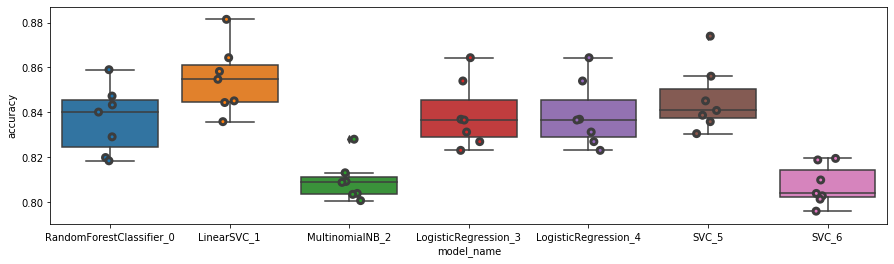

In [45]:
import seaborn as sns

# Initialize Figure and Axes object
fig, ax = plt.subplots(figsize=(15,4))

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=6, jitter=True, edgecolor="gray", linewidth=3)
plt.show()

The above plot proves that a Linear SVC model predicts the candidates most accurately.

# Hyperparameter Tuning

Use `GridSearchCV` to tune the `C` and `gamma` parameters

# Create the GridSearchCV model

In [18]:
model = SVC(kernel='linear')
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [ 390, 400, 410],
              'gamma': [0.000000004,0.000000005,0.000000006]}
grid = GridSearchCV(model, param_grid, verbose=3)

In [19]:
# Train the model with GridSearch
grid.fit(X_train_minmax, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] C=390, gamma=4e-09 ..............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................. C=390, gamma=4e-09, score=0.887, total=   2.3s
[CV] C=390, gamma=4e-09 ..............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s


[CV] .................. C=390, gamma=4e-09, score=0.891, total=   1.8s
[CV] C=390, gamma=4e-09 ..............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.1s remaining:    0.0s


[CV] .................. C=390, gamma=4e-09, score=0.886, total=   2.5s
[CV] C=390, gamma=5e-09 ..............................................
[CV] .................. C=390, gamma=5e-09, score=0.887, total=   2.0s
[CV] C=390, gamma=5e-09 ..............................................
[CV] .................. C=390, gamma=5e-09, score=0.891, total=   1.6s
[CV] C=390, gamma=5e-09 ..............................................
[CV] .................. C=390, gamma=5e-09, score=0.886, total=   2.4s
[CV] C=390, gamma=6e-09 ..............................................
[CV] .................. C=390, gamma=6e-09, score=0.887, total=   2.0s
[CV] C=390, gamma=6e-09 ..............................................
[CV] .................. C=390, gamma=6e-09, score=0.891, total=   1.8s
[CV] C=390, gamma=6e-09 ..............................................
[CV] .................. C=390, gamma=6e-09, score=0.886, total=   2.6s
[CV] C=400, gamma=4e-09 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:   58.2s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='linear',
                           max_iter=-1, probability=False, random_state=None,
                           shrinking=True, tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [390, 400, 410], 'gamma': [4e-09, 5e-09, 6e-09]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [20]:
print(grid.best_params_)
print(grid.best_score_)

{'C': 390, 'gamma': 4e-09}
0.8879231473010064


In [21]:
# Make predictions with the hypertuned model
predictions = grid.predict(X_test_minmax)

In [22]:
# Calculate classification report
print(classification_report(y_test, predictions,
                target_names=['CANDIDATE', 'CONFIRMED', 'FALSE POSITIVE']))

                precision    recall  f1-score   support

     CANDIDATE       0.85      0.69      0.76       529
     CONFIRMED       0.76      0.87      0.81       568
FALSE POSITIVE       0.98      1.00      0.99      1089

      accuracy                           0.89      2186
     macro avg       0.86      0.85      0.85      2186
  weighted avg       0.89      0.89      0.89      2186



In [23]:
model2 = SVC(kernel='rbf')
param_grid2 = {'C': [ 10000, 25000], 'gamma': [0.005, 0.01]}
grid2 = GridSearchCV(model2, param_grid2, verbose=3)
# Train the model with GridSearch
grid2.fit(X_train_minmax, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] C=10000, gamma=0.005 ............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................ C=10000, gamma=0.005, score=0.880, total=   0.9s
[CV] C=10000, gamma=0.005 ............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] ................ C=10000, gamma=0.005, score=0.886, total=   0.8s
[CV] C=10000, gamma=0.005 ............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV] ................ C=10000, gamma=0.005, score=0.886, total=   0.9s
[CV] C=10000, gamma=0.01 .............................................
[CV] ................. C=10000, gamma=0.01, score=0.882, total=   0.9s
[CV] C=10000, gamma=0.01 .............................................
[CV] ................. C=10000, gamma=0.01, score=0.891, total=   1.0s
[CV] C=10000, gamma=0.01 .............................................
[CV] ................. C=10000, gamma=0.01, score=0.889, total=   1.1s
[CV] C=25000, gamma=0.005 ............................................
[CV] ................ C=25000, gamma=0.005, score=0.884, total=   1.1s
[CV] C=25000, gamma=0.005 ............................................
[CV] ................ C=25000, gamma=0.005, score=0.892, total=   0.9s
[CV] C=25000, gamma=0.005 ............................................
[CV] ................ C=25000, gamma=0.005, score=0.890, total=   0.9s
[CV] C=25000, gamma=0.01 .............................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   11.4s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [10000, 25000], 'gamma': [0.005, 0.01]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [24]:
print(grid2.best_params_)
print(grid2.best_score_)

{'C': 25000, 'gamma': 0.01}
0.8899054589813967


In [25]:
# Make predictions with the hypertuned model
predictions = grid2.predict(X_test_minmax)
print(classification_report(y_test, predictions,
                target_names=['CANDIDATE', 'CONFIRMED', 'FALSE POSITIVE']))

                precision    recall  f1-score   support

     CANDIDATE       0.84      0.71      0.77       529
     CONFIRMED       0.77      0.85      0.81       568
FALSE POSITIVE       0.98      1.00      0.99      1089

      accuracy                           0.89      2186
     macro avg       0.86      0.85      0.86      2186
  weighted avg       0.89      0.89      0.89      2186

